In [38]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


np.random.seed(42)
tf.random.set_seed(42)

**Load Images**

In [39]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

data_dir = './brain-mri-images-for-brain-tumor-detection/'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


**Image Demonstration**

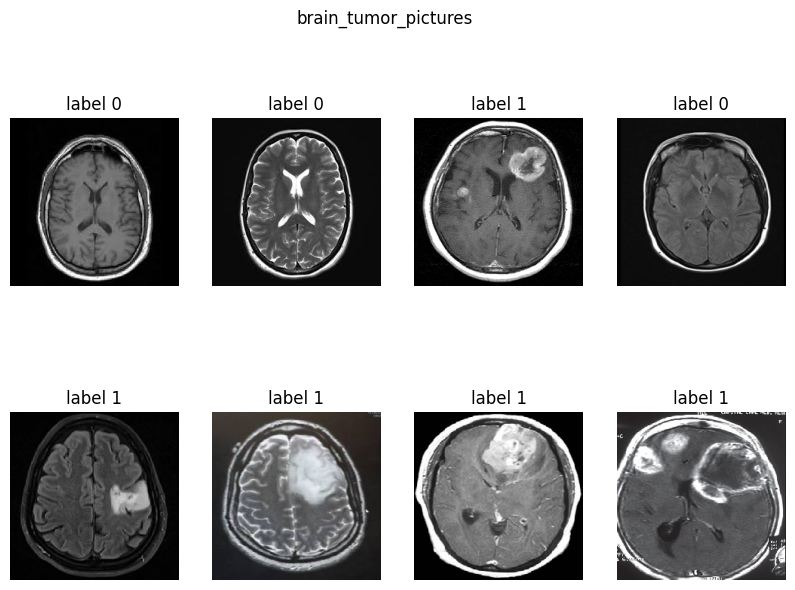

In [40]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

**CNN Implementation**

In [41]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [42]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 7.4325 - acc: 0.5911
Epoch 1: acc improved from -inf to 0.59113, saving model to model\vgg19_best.h5
4/4 [==============================] - 25s 8s/step - loss: 7.4325 - acc: 0.5911 - val_loss: 5.8653 - val_acc: 0.3800


c:\Users\devan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 5.1570 - acc: 0.6158
Epoch 2: acc improved from 0.59113 to 0.61576, saving model to model\vgg19_best.h5
4/4 [==============================] - 24s 6s/step - loss: 5.1570 - acc: 0.6158 - val_loss: 6.5417 - val_acc: 0.6600
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 3.5236 - acc: 0.7143
Epoch 3: acc improved from 0.61576 to 0.71429, saving model to model\vgg19_best.h5
4/4 [==============================] - 24s 6s/step - loss: 3.5236 - acc: 0.7143 - val_loss: 3.1712 - val_acc: 0.7000
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 1.9548 - acc: 0.7488
Epoch 4: acc improved from 0.71429 to 0.74877, saving model to model\vgg19_best.h5
4/4 [==============================] - 24s 6s/step - loss: 1.9548 - acc: 0.7488 - val_loss: 2.8018 - val_acc: 0.7800
Epoch 5/25
4/4 [==============================] - ETA: 0s - loss: 2.5196 - acc: 0.7980
Epoch 5: acc improved from 0.74877 to 0.79803, savin

In [43]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 5s 5s/step - loss: 0.6713 - acc: 0.8400


,Train,Val
Loss,0.003715,0.671329
Acc,1.000000,0.840000


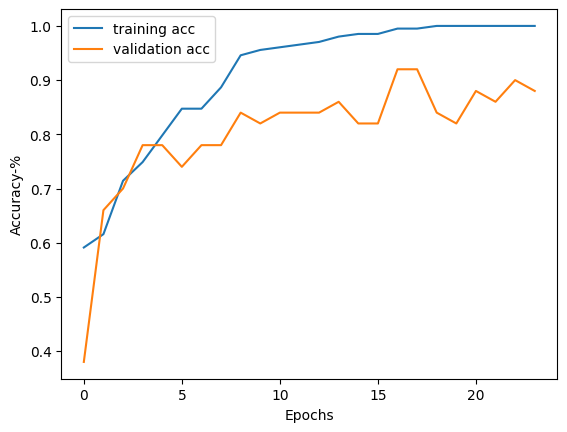

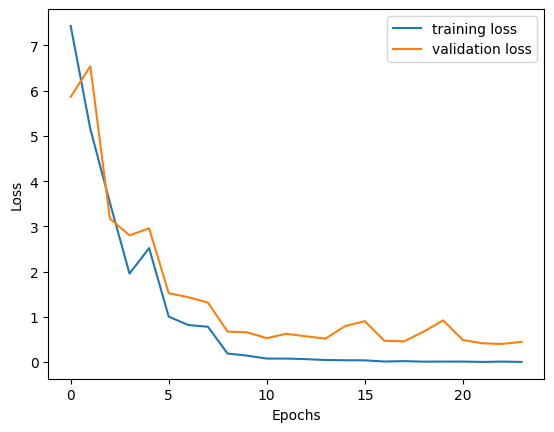

In [44]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

**Adding Image augmentation**

In [45]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [46]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.5043 - acc: 0.8458
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 32s 8s/step - loss: 0.5043 - acc: 0.8458 - val_loss: 0.4734 - val_acc: 0.8800 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.5509 - acc: 0.8419
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 33s 9s/step - loss: 0.5509 - acc: 0.8419 - val_loss: 0.2853 - val_acc: 0.9200 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.3156 - acc: 0.8735
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 31s 8s/step - loss: 0.3156 - acc: 0.8735 - val_loss: 0.1968 - val_acc: 0.9400 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.3456 - acc: 0.8696
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 32s 8s/step - loss: 0.3456 - acc: 0.8696 - val_loss: 0.

**VGG 19 model results**

In [47]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 5s 5s/step - loss: 0.0992 - acc: 0.9400


,Train,Val
Loss,0.004212,0.099182
Acc,1.000000,0.940000


In [48]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

2/2 [==============================] - 5s 2s/step
[[16  3]
 [ 0 31]]

               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.91      0.95        34

    accuracy                           0.94        50
   macro avg       0.92      0.96      0.93        50
weighted avg       0.95      0.94      0.94        50



In [49]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21933857 (83.67 MB)
Trainable params: 131073 (512.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [50]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.0698 - acc: 0.6601
Epoch 1: acc improved from -inf to 0.66010, saving model to model\inceptionv3_best.h5


c:\Users\devan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 15s 3s/step - loss: 1.0698 - acc: 0.6601 - val_loss: 0.7913 - val_acc: 0.9200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.3527 - acc: 0.9163
Epoch 2: acc improved from 0.66010 to 0.91626, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 9s 2s/step - loss: 0.3527 - acc: 0.9163 - val_loss: 1.3317 - val_acc: 0.8800
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.3008 - acc: 0.9409
Epoch 3: acc improved from 0.91626 to 0.94089, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 8s 2s/step - loss: 0.3008 - acc: 0.9409 - val_loss: 1.0392 - val_acc: 0.9000
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.1011 - acc: 0.9655  
Epoch 4: acc improved from 0.94089 to 0.96552, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 9s 3s/step - loss: 0.1011 - acc: 0.9655 - val_loss: 0.7713 - val_acc: 0.9000
Epoch

In [51]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.6161 - acc: 0.9400


,Train,Val
Loss,0.011039,0.616137
Acc,0.995074,0.940000


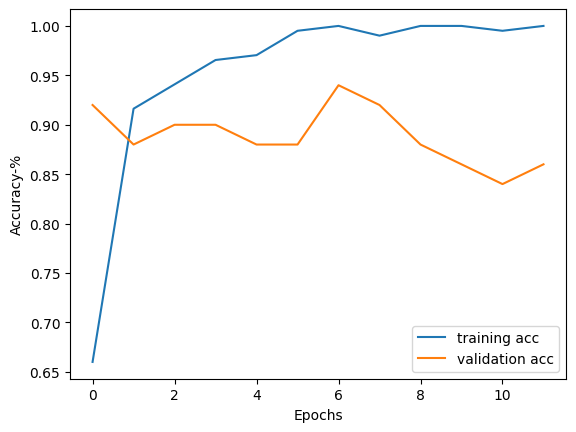

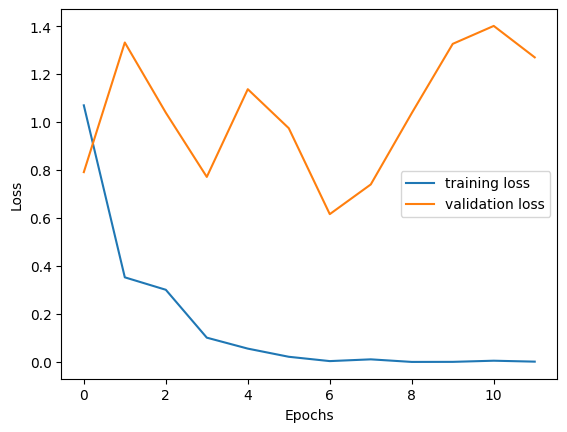

In [52]:
plot_learning_curve(history)

In [53]:
#Adding Image augmentation

aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 1.7794 - acc: 0.8221
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 12s 3s/step - loss: 1.7794 - acc: 0.8221 - val_loss: 2.4362 - val_acc: 0.7400 - lr: 0.0010
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 1.4178 - acc: 0.8182
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 12s 3s/step - loss: 1.4178 - acc: 0.8182 - val_loss: 1.0625 - val_acc: 0.8600 - lr: 0.0010
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.8674 - acc: 0.8617
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 12s 3s/step - loss: 0.8674 - acc: 0.8617 - val_loss: 0.5173 - val_acc: 0.9400 - lr: 0.0010
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.8829 - acc: 0.8498
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 12s 3s/step - 

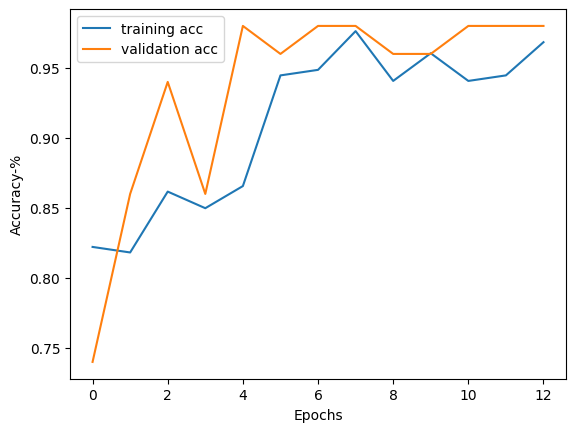

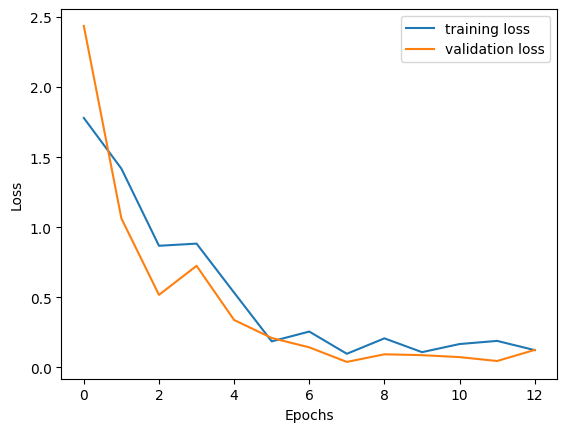

In [54]:
plot_learning_curve(history)

In [55]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.0387 - acc: 0.9800


,Train,Val
Loss,0.022040,0.038673
Acc,0.990148,0.980000
